<a href="https://colab.research.google.com/github/igordantasgf/analise_dados_microambientais/blob/main/fly_eye_visualize.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
col = ['TIMESTAMP', '"RECORD"', '"rtime"', '"batt_volt"', '"panel_temp"', '"CM3Up_mv_Avg"', '"CM3Up_Wm2_Avg"', '"CMP21_Avg"', '"CMP21_Wm2_Avg"', '"CelSol_01_Avg"', '"CelSol_02_Avg"', '"CelSol_03_Avg"', '"CelSol_04_Avg"', '"CelSol_05_Avg"', '"CelSol_06_Avg"', '"CelSol_07_Avg"', '"CelSol_08_Avg"', '"CelSol_09_Avg"', '"CelSol_10_Avg"', '"CelSol_11_Avg"', '"CelSol_12_Avg"', '"CelSol_13_Avg"', '"CelSol_14_Avg"', '"CelSol_15_Avg"', '"CelSol_16_Avg"', '"CelSol_17_Avg"']
labmim = pd.read_csv('/content/drive/MyDrive/Bolsa - Edson/plataforma/LBM_solar_2022.dat',sep=';', header=None,skiprows=lambda x:x in [0,1,2,3], names=col)
labmim[col] = labmim.TIMESTAMP.str.split(",", expand = True)

In [ ]:
def calcular_nan():
  count = labmim.isna().any(axis=1).sum()
  print(f"Number of rows with at least one NaN value: {count}")
  print(f"Total rows in series: {len(labmim)}")
calcular_nan()

Number of rows with at least one NaN value: 0
Total rows in series: 459301


### Organização dos valores
##### Sequenciamento dos valores e suas respectivas coordenadas bidimensionais em duas litas separadas 

In [ ]:
sensors=col[9:]
labmim_backup = labmim

for i in sensors:
  x=0
  unique_types = set()
  #for item in labmim_backup[i]:
  #  unique_types.add(type(item))
  #print(unique_types)
  labmim_backup[i] = [int(x) if str(x).isdigit() else 0 for x in labmim_backup[i]]

In [99]:
#@markdown #### Função para separar valores (soma, média d.m., média h.m, etc)
#@markdown **gerar_valores(tabela, var)**
sensors=col[9:]

def gerar_valores(tabela,var):
  values=[]
  if var==0: #@markdown - 0 = Soma de todos os valores da série
    for i in sensors:
      values.append(sum(labmim_backup[i]))
    final = [values[0:8],values[8:16],[values[16]]*8]
    return final

In [100]:
from scipy.interpolate import interp2d

# Definindo a matriz original
matriz_original = gerar_valores(labmim_backup, 0)

# Definindo as coordenadas dos valores na nova matriz
coordenadas = np.array([[[28,11],[28,22],[28,33],[28,44],[28,55],[28,66],[28,77],[28,88]], 
                        [[25,11],[25,22],[25,33],[25,44],[25,55],[25,66],[25,77],[25,88]], 
                        [[7,11],[7,22],[7,33],[7,44],[7,55],[7,66],[7,77],[7,88]]])

# Definindo a grade da nova matriz
x_new = np.linspace(0, 99, 100)
y_new = np.linspace(0, 29, 30)

# Criando uma função interpoladora
f = interp2d(coordenadas[:, :, 1], coordenadas[:, :, 0], matriz_original, kind='cubic')

# Aplicando a função interpoladora na nova grade
nova_matriz = f(x_new, y_new)


<ipython-input-100-46ab2b201ef8>:16: DeprecationWarning: `interp2d` is deprecated!
`interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.12.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://gist.github.com/ev-br/8544371b40f414b7eaf3fe6217209bff`

  f = interp2d(coordenadas[:, :, 1], coordenadas[:, :, 0], matriz_original, kind='cubic')
/usr/local/lib/python3.10/dist-packages/scipy/interpolate/_fitpack_impl.py:975: RuntimeWarning: No more knots can be added because the number of B-spline
coefficients already exceeds the number of data points m.
Probable causes: either s or m too small. (fp>s)
	kx,ky=3,3 nx,ny=11,8 m=24 fp=95959466453.091156 s=0.000000
  warnings.warn(RuntimeWarning(_ier

<ipython-input-135-c6504e95dc7e>:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  orig_map=plt.cm.get_cmap('hot')


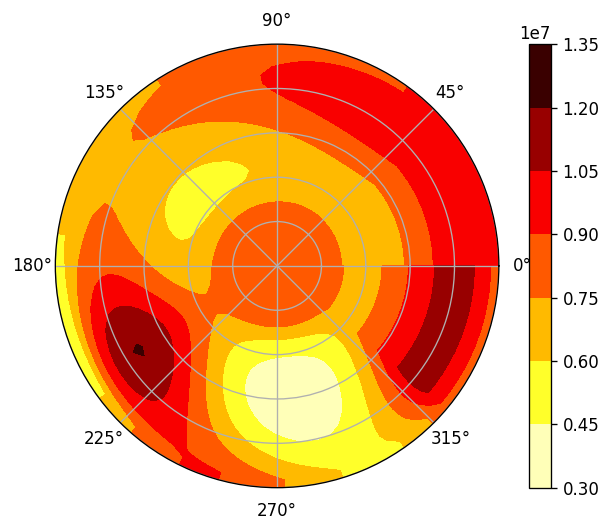

In [135]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pandas as pd

#fake data:
a = np.linspace(0,2*np.pi,100) # Sepação das partes em radianos
b = np.linspace(0,1,30) # Camadas por distancia ao centro
A, B = np.meshgrid(a, b)
c = nova_matriz

orig_map=plt.cm.get_cmap('hot')

#actual plotting
fig, ax = plt.subplots(dpi=120,subplot_kw=dict(projection='polar'))
ax.set_yticklabels([])
ctf = ax.contourf(a, b, c, cmap=orig_map.reversed())
plt.colorbar(ctf)

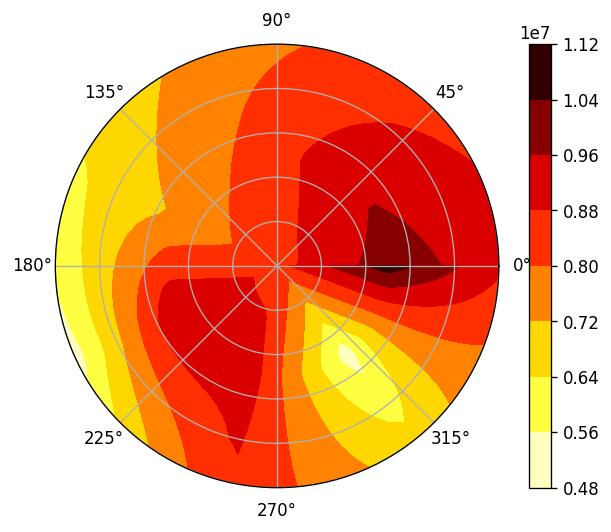

In [189]:
import numpy as np
from scipy.interpolate import RegularGridInterpolator
import matplotlib.pyplot as plt

# Define the original matrix
original_matrix = gerar_valores(labmim_backup, 0)

# Define the coordinates of the values in the original matrix
r = np.linspace(0, 1, 3)
theta = np.linspace(0, 2*np.pi, 8)
R, Theta = np.meshgrid(r, theta)
x = R * np.cos(Theta)
y = R * np.sin(Theta)

# Define the coordinates of the values in the interpolated matrix
new_r = np.linspace(0, 1, 30)
new_theta = np.linspace(0, 2*np.pi, 100)
new_Theta, new_R = np.meshgrid(new_theta, new_r)
new_x = new_R * np.cos(new_Theta)
new_y = new_R * np.sin(new_Theta)

# Create a two-dimensional interpolation function
interp_func = RegularGridInterpolator((r, theta), original_matrix)

# Apply the interpolation function to the new coordinates
new_matrix = interp_func((new_R, new_Theta))

fig, ax = plt.subplots(dpi=120,subplot_kw=dict(projection='polar'))
ax.set_yticklabels([])
ctf = ax.contourf(new_Theta,np.flip(new_R,0), new_matrix, cmap=orig_map.reversed())
plt.colorbar(ctf)